In [90]:
#Import Libraries

import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
#Define the Dates
training_start = "2014-01-01"
training_end = "2015-08-26"
treatment_start = "2015-09-02"
treatment_end = "2015-09-30"
end_stock = "2015-10-01"

In [92]:
#Dowload Volkswagen stock
y = ["VOW.DE"]
y = yf.download(y,
                start = training_start,
                end = end_stock,
                interval = "1d")
y = y['Adj Close'].rename("y")
print(y) 

[*********************100%***********************]  1 of 1 completed
Date
2014-01-02    158.372711
2014-01-03    157.596176
2014-01-06    157.105713
2014-01-07    158.209229
2014-01-08    157.923141
                 ...    
2015-09-24    101.477425
2015-09-25     98.618324
2015-09-28     91.406494
2015-09-29     88.163322
2015-09-30     89.571548
Name: y, Length: 442, dtype: float64


In [93]:
#Load more data
stocks = ["META", "DIS", "NVS", "CARL-B.CO"]
X = yf.download(tickers = stocks,
                start = training_start,
                end = end_stock,
                interval = "1d")
X = X.iloc[:, :len(stocks)]
X.columns = X.columns.droplevel()
print(X.head())

[*********************100%***********************]  4 of 4 completed
             CARL-B.CO        DIS       META        NVS
Date                                                   
2014-01-02  492.879822  70.192520  54.709999  51.280930
2014-01-03  494.123444  70.045273  54.560001  51.534988
2014-01-06  492.879822  69.778381  57.200001  51.587105
2014-01-07  496.196167  70.256935  57.919998  51.769505
2014-01-08  487.905518  69.226189  58.230000  51.925846


In [94]:
#Combine everything
X.index = X.index.tz_localize(None) 
y.index = y.index.tz_localize(None)
df = pd.concat([y, X], axis = 1).dropna()
print(df.head())

                     y   CARL-B.CO        DIS       META        NVS
Date                                                               
2014-01-02  158.372711  492.879822  70.192520  54.709999  51.280930
2014-01-03  157.596176  494.123444  70.045273  54.560001  51.534988
2014-01-06  157.105713  492.879822  69.778381  57.200001  51.587105
2014-01-07  158.209229  496.196167  70.256935  57.919998  51.769505
2014-01-08  157.923141  487.905518  69.226189  58.230000  51.925846


In [95]:
#subsetting just the training data
df_training = df[df.index <= training_end]
print(df_training.tail())

                     y   CARL-B.CO        DIS       META        NVS
Date                                                               
2015-08-20  143.425446  442.690918  93.762146  90.559998  69.693520
2015-08-21  140.822342  440.552307  92.655968  86.059998  67.553886
2015-08-24  135.317474  423.443512  89.393700  82.089996  65.649696
2015-08-25  143.212067  424.983276  89.890549  83.000000  65.878197
2015-08-26  141.633148  419.679596  93.021591  87.190002  67.256149


In [96]:

# #Stationarity check
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller test - to check for stationarity

def check_p_value(timeseries):
    
    result = adfuller(timeseries)
    
    message = None 
    
    if result[1] > 0.05:
        message = "The timeseries is not stationary."
    else:
        message = "The timeseries is stationary."
    
    return result[1], message

stationary_df = df_training.pct_change().dropna()

stationarity_p_value, message = check_p_value(stationary_df.y)

print('p-value for stationarity test: ', round(stationarity_p_value,3)) 
print(message)

p-value for stationarity test:  0.0
The timeseries is stationary.


In [98]:
# # import business_analytics_api as ba # import the business analytics API
# from business_analytics_api import StationarityHelper # import the StationarityHelper class

# p_value, message = stationary_timeseries = StationarityHelper(timeseries = df_training.y).check_p_value() 

# print('p_value - original timeseries: ', p_value)
# print('message - original timeseries: ', message)

# print('\n--------------------------------------\n')

# stationary_timeseries = StationarityHelper(timeseries = df_training.y).make_data_stationary() 
# p_value, message = StationarityHelper(timeseries = stationary_timeseries).check_p_value()

# print('p_value - differenced timeseries: ', p_value)    
# print('message - differenced timeseries: ', message)


ImportError: cannot import name 'StationarityHelper' from 'business_analytics_api' (c:\Users\jasonmelman\Development\Business Analyst - Course Materials\business_analytics_api\__init__.py)

AxesSubplot(0.125,0.11;0.62x0.77)


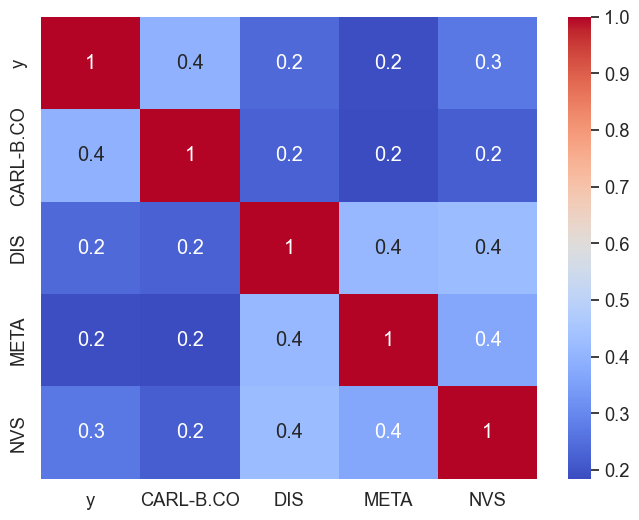

In [ ]:
#Correlation matrix
plt.figure(figsize = (8,6))
sns.set(font_scale=1.2)
corr_hm = sns.heatmap(data = stationary_df.corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'coolwarm')
print(corr_hm)

In [ ]:
#removing unwanted time series
stationary_df = stationary_df.drop(columns = ["META","DIS"])

In [ ]:
#Define pre and post period
# get min "Date" from df
min_date = df.index.min()
print('min_date: ', min_date)
pre_period = [min_date, training_end]
post_period = [treatment_start, treatment_end]

min_date:  2014-01-02 00:00:00


In [ ]:
#Causal Impact
impact = CausalImpact(
    data = df,
    pre_period = pre_period,
    post_period = post_period
)


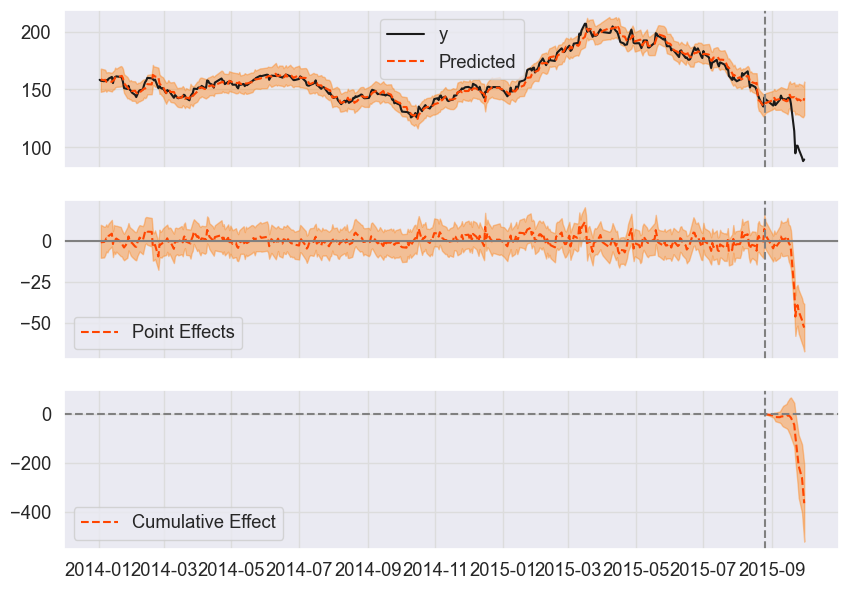

None


In [ ]:
# vizualization
print(impact.plot())

In [ ]:

print(impact.summary())


Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    123.51             2470.11
Prediction (s.d.)         141.73 (4.09)      2834.59 (81.77)
95% CI                    [134.16, 150.18]   [2683.1, 3003.64]

Absolute effect (s.d.)    -18.22 (4.09)      -364.48 (81.77)
95% CI                    [-26.68, -10.65]   [-533.53, -212.99]

Relative effect (s.d.)    -12.86% (2.88%)    -12.86% (2.88%)
95% CI                    [-18.82%, -7.51%]  [-18.82%, -7.51%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [ ]:
#summary - report
print(impact.summary(output = 'report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 123.51. By contrast, in the absence of an
intervention, we would have expected an average response of 141.73.
The 95% interval of this counterfactual prediction is [134.16, 150.18].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -18.22 with a 95% interval of
[-26.68, -10.65]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 2470.11.
By contrast, had the intervention not taken place, we would have expected
a sum of 2834.59. The 95% interval of this prediction is [2683.1, 3003.64].


The above results are given in terms of absolute numbers. In relative
terms, the respo